Imports

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage import transform
import numpy as np
import pywt
from torch.utils.data import Dataset
import PIL.Image as Image

# !pip install datasets==2.15
# import datasets

# !pip install kornia
# import kornia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

WaveMixSR

In [18]:
class Level1Waveblock(nn.Module):
    def __init__(self, c):
        super(Level1Waveblock, self).__init__()
        self.conv = nn.Conv2d(c, c // 4, 3,padding = 1)
        self.feedforward = nn.Sequential(
            nn.Conv2d(c, c, 1),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv2d(c, c, 1),
            nn.ConvTranspose2d( c, c, 4, stride=2, padding=1),
            nn.BatchNorm2d(c)
        )


    def haar_wavelet_transform(self, x):
        batch_size, coefficients = x.size(0), []

        for i in range(batch_size):
            image = x[i]
            image_np = image.detach().cpu().numpy()
            image_coefficients = []

            for channel in image_np:
                aa,(ad,da,dd) = pywt.dwt2(channel, 'haar')
                image_coefficients.append(aa)
                image_coefficients.append(ad)
                image_coefficients.append(da)
                image_coefficients.append(dd)

            coefficients.append(image_coefficients)

        return torch.tensor(np.array(coefficients)).to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.haar_wavelet_transform(x)
        x = self.feedforward(x)
        return x.to(device)

In [19]:
import torch.nn as nn
import torchvision.models as models

class WaveMixSR(nn.Module):
    def __init__(self, depth, c):
        super(WaveMixSR, self).__init__()
        vgg11 = models.vgg11().to(device)
        
        # Load the pre-trained weights from the given path
        pre_trained_weights = torch.load("/kaggle/input/vgg-net/vgg11-8a719046.pth")
        vgg11.load_state_dict(pre_trained_weights)

        # Get the first three layers from VGG11
        self.vgg_layers = nn.Sequential(*list(vgg11.features.children())[:3]).to(device)

        # WaveMixSR layers
        self.layers = nn.ModuleList([Level1Waveblock(c) for _ in range(depth)])

        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.Conv2d(8, 3, 3, stride=1, padding=1),
        )

        # Use VGG11's initial layers in self.path1
        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=7, mode='bicubic', align_corners=False),
            self.vgg_layers,  # Use VGG11's first three layers
        )

    def forward(self, img):

        y = self.path1(img)

        # Apply WaveMixSR layers
        for layer in self.layers:
            y = layer(y) + y

        # Final transformation to convert back to 1-channel
        y = self.final(y)
        
        resize_transform = transforms.Resize((128, 128))

        # Apply the transformation
        img_resized = resize_transform(y)

        # Concatenate the Y and CrCb components
        return img_resized.to(device)

Loss

In [20]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(torch.sqrt(torch.abs(torch.max(img1)))/ torch.sqrt(mse)).to('cuda')

class PSNRLoss(torch.nn.Module):
    def __init__(self):
        super(PSNRLoss, self).__init__()

    def forward(self, img1, img2):
        return -psnr(img1, img2).to(device)

Dataset

In [21]:
# !unzip '/content/drive/MyDrive/archive.zip'

In [22]:
from keras.datasets import mnist
from keras.utils import to_categorical
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, dataset, upscale_factor):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]
        img_pil = Image.fromarray(img.astype('uint8'))
        img_ycbcr = img_pil.convert('YCbCr')
        lr_img = self.transform(img_ycbcr)
        hr_img = transforms.ToTensor()(img_ycbcr)

        return lr_img, hr_img

# (train_X, _), (test_X, _) = mnist.load_data()

import os
from sklearn.model_selection import train_test_split

image_dir = '/kaggle/input/dataset/flowers/flowers'
image_files = np.array([Image.open(os.path.join(image_dir, file)) for file in os.listdir(image_dir)])
train_X, test_X = train_test_split(image_files, test_size=0.2, random_state=42)

upscale_factor = 2

train_dataset = SuperResolutionDataset(train_X[0:100], upscale_factor)
test_dataset = SuperResolutionDataset(test_X[0:100], upscale_factor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

Model

In [28]:
model = WaveMixSR(depth=4, c=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = PSNRLoss()

Training

In [29]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_function(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

Epoch 1/50, Loss: -10.181929588317871
Epoch 2/50, Loss: -17.670518112182616
Epoch 3/50, Loss: -20.279869689941407
Epoch 4/50, Loss: -21.80173538208008
Epoch 5/50, Loss: -22.931514816284178
Epoch 6/50, Loss: -23.663874053955077
Epoch 7/50, Loss: -25.18696807861328
Epoch 8/50, Loss: -26.377522735595704
Epoch 9/50, Loss: -26.792214889526367
Epoch 10/50, Loss: -25.877595520019533
Epoch 11/50, Loss: -26.40867965698242
Epoch 12/50, Loss: -27.02895278930664
Epoch 13/50, Loss: -27.267895965576173
Epoch 14/50, Loss: -27.569806060791016
Epoch 15/50, Loss: -28.318294067382812
Epoch 16/50, Loss: -28.89458511352539
Epoch 17/50, Loss: -28.806723327636718
Epoch 18/50, Loss: -29.260499114990235
Epoch 19/50, Loss: -28.849112548828124
Epoch 20/50, Loss: -29.507491455078124
Epoch 21/50, Loss: -29.857430419921876
Epoch 22/50, Loss: -29.627805328369142
Epoch 23/50, Loss: -29.346491394042967
Epoch 24/50, Loss: -29.851304168701173
Epoch 25/50, Loss: -29.894027252197265
Epoch 26/50, Loss: -30.09149528503418
E

Testing

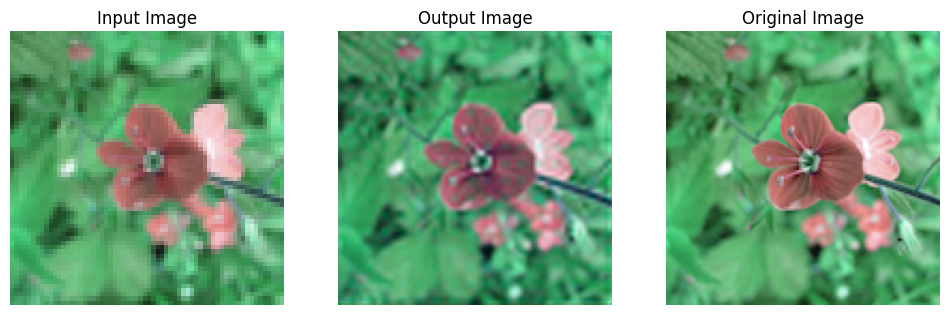

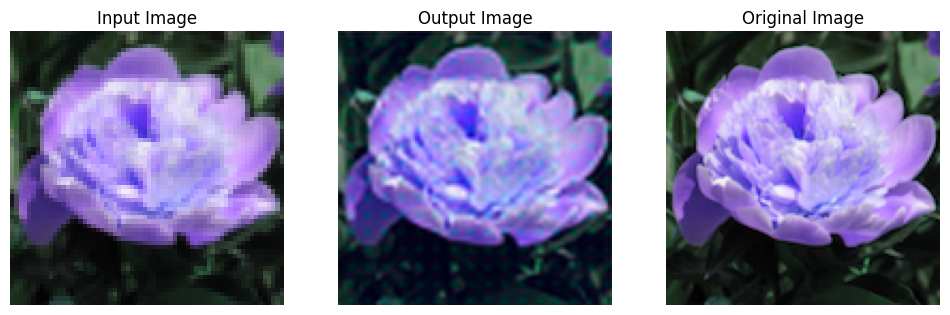

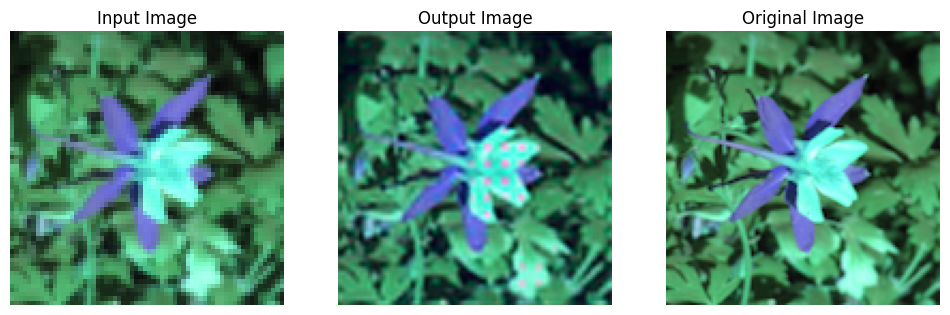

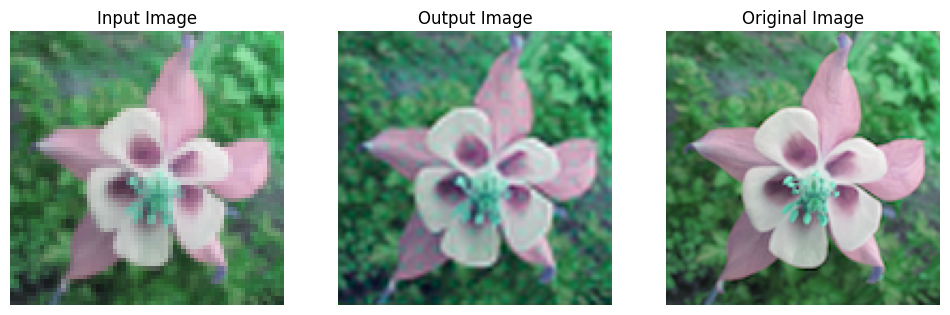

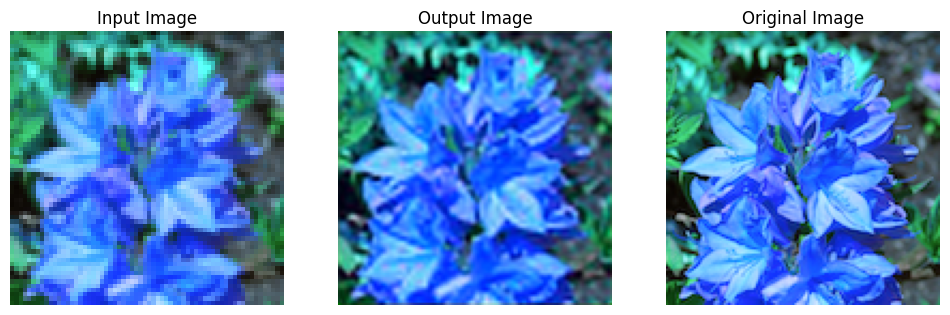

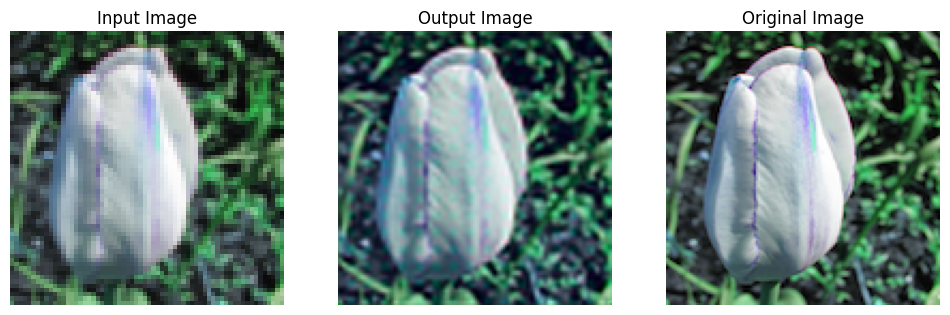

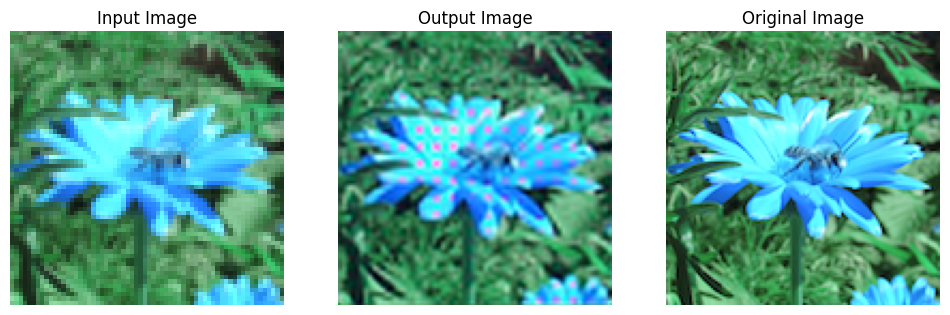

Average PSNR on test set: 27.13965824672154


In [30]:
import matplotlib.pyplot as plt
import cv2

model.eval()
total_psnr = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.to(device))
        psnr_value = psnr(outputs, targets.to(device))
        total_psnr += psnr_value.item()

        input_image = inputs[0].permute(1, 2, 0).cpu().numpy()
        output_image = outputs[0].permute(1, 2, 0).cpu().numpy()
        target_image = targets[0].permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.show()

average_psnr = total_psnr / len(test_loader)
print(f"Average PSNR on test set: {average_psnr}")